In [1]:
# ---
# date: 2024-05-29
# excerpt: Using the SICOPOLIS model, we simulate the Greenland ice sheet under a high-emissions scenario.
# ---

# Simulating an ice sheet

Most of our future projections about the effects of climate change are informed by computer models. These models are based on the laws of physics and aim to capture a part of the climate system (e.g. the atmosphere, the ocean, the ice sheets). They can stand alone, or they can be coupled to other models to better represent the feedback loops that often exist at the boundaries of Earth's systems. Atmospheric warming results in a warmer ocean, which *likely* affects ocean circulation (such as the thermohaline pump) and currents (like El Niño and La Niña), all of which accelerate the melting of ice sheets, which reduces the amount of sunlight reflected, in turn warming the atmosphere more... you get the point. It's all interconnected.

In this post we'll be focusing on a single part of this system: the Greenland ice sheet. It's the second largest body of ice in the world next to Antarctica, but it's melting the fastest: it's estimated to have lost around $243\ \text{Gt}$ per year over the period 2010-2019. In contrast, the Antarctic sheet's estimated loss rate is "only" $148\ \text{Gt}\ \text{yr}^{-1}$ over that same period.[^1]

We'll be using the [SICOPOLIS](https://www.sicopolis.net) model to simulate the evolution of the Greenland ice-sheet under a particular high-emissions scenario. But what is a model, and why should you care?

[^1]: IPCC, 2021: *"Climate Change 2021: The Physical Science Basis"*. Chapter 9 [supplementary material](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter09_SM.pdf), table 9.SM.1.

## Ice-sheet models

A *model* is a simplification of reality. When we neglect air resistance, assume a spherical cow, or say that a car uses a certain amount of fuel per distance traveled (even though this depends on the speed of the car), we are creating a model. This means that they're fundamentally ignoring things by not taking them into account, but as the famous quote attributed to George Box goes:

> All models are wrong, but some are useful.

The thing that makes models *"wrong"* is also what makes them *useful* most of the time. It would take centuries to simulate every single atom in the Greenland sheet, but realizing that the forces that dominate glacier movements happen on a much larger scale is the key that allows us to simplify. Of course, these are assumptions that you should test, but that's part of the scientific process. One way of validating models is by having them "predict the past", which we can compare to historical data like the geological record.

Most computer models operate using a fundamental equation:

$$
\begin{equation}
  x(t_{i+1}) = \mathcal{L}(x(t_i))
\end{equation}
$$

This is saying that our **state** $x$ at the next timestep $t_{i+1}$ is given by some function $\mathcal{L}$ (our model) applied to the state at the current timestep $t_i$. In ice-sheet models, that function $\mathcal{L}$ contains 2 main physical processes (usually in the form of partial differential equations):

1. Snow fall and melt (which together make up the *surface mass balance*)
2. Ice flow; the physical movement of the glacier (internal deformation, basal *sliding*, calving)

Some models will include more or less detail based on the assumptions they make (mostly related to internal stresses): the shallow ice and shallow shelf approximation being the most common. I won't go into more depth on them here but if you want to read more about these processes and assumptions, I recommend the `antarcticglaciers.org` page: they have great sources on [glacier flow](https://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow/) and [mass balance](https://www.antarcticglaciers.org/glacier-processes/mass-balance/glacier-accumulation-and-ablation/), for example.

Apart from these processes, models also rely on *external inputs*. This can be temperature, precipitation or sea level data, but also the initial state of the ice sheet. These are the knobs we can turn, after which we let the physics play it out. And it's with this step in mind that we can start modeling our ice sheet!

## Setup


We're going to start by [installing](https://sicopolis.readthedocs.io/en/latest/getting_started.html) SICOPOLIS. Installing NetCDF can be quite a hassle on MacOS (which I am); I recommend using [MacPorts](https://ports.macports.org/port/netcdf-fortran/) in that case. Note that we won't really need LIS (we're only simulating land ice), so you can skip that part of the installation if you want.

<Note type="info">
If you want to follow along, this whole article is available as an executable Jupyter notebook [here](https://link.com).
</Note>

After it's installed, we're going to retrieve the input data for our model run. We're going to need to tell the model what the temperature is going to be in the future. I'm going to use one of the IPCC's Representative Concentration Pathways (RCP), which is a scenario of our future CO<sub>2</sub> emissions. I'm going to go with the quite pessimistic emissions scenario [RCP 8.5](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway#RCP_8.5), so we can really see the difference in the ice sheet. The original RCP scenarios are only defined until 2100, so we're going to use ECP 8.5 (*Extended Concentration Pathway*), which extends until 2300.[^2]

[^2]: van Vuuren, Detlef P., et al. *“The Representative Concentration Pathways: An Overview.”* Climatic Change, vol. 109, no. 1–2, Springer Science and Business Media LLC, 5 Aug. 2011, pp. 5–31. [doi:10.1007/s10584-011-0148-z](https://psl.noaa.gov/ipcc/cmip5/rcp.pdf).

<Image
    caption={<span>RCP and ECP emissions scenarios. Reproduced from <FootnoteLabel nosup>2</FootnoteLabel>. </span>}
    maxHeight={275}
    src="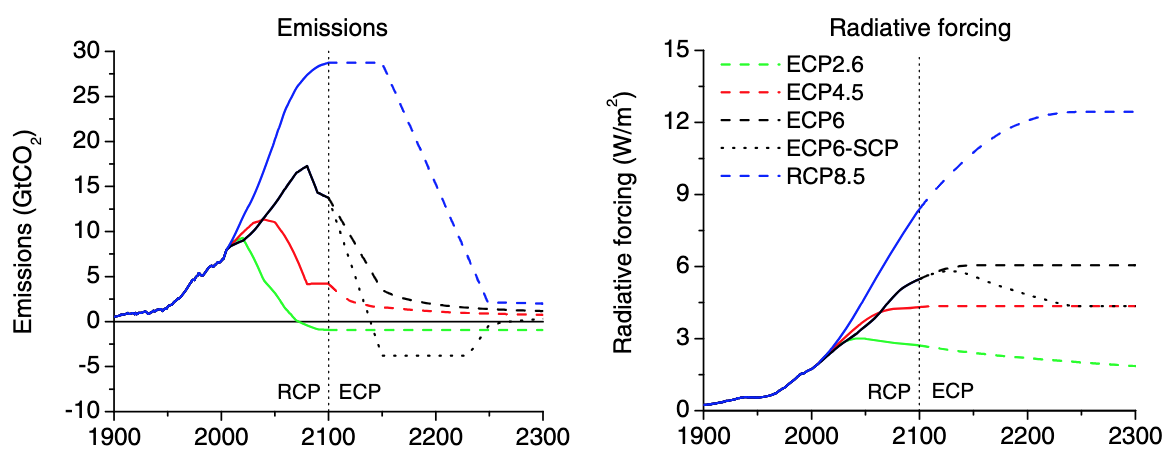"
/>

This is, however, only emissions data: we don't know what effect this will have on temperature. Luckily, people have taken these emissions scenarios and run them through computer simulations for us. Thanks to [CMIP5](https://pcmdi.llnl.gov/mips/cmip5/), these simulations produce standardized data that we get to compare and browse in a single place. I personally prefer the Copernicus Climate Data Store, so head over there and have a look at the [CMIP5 monthly data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip5-monthly-single-levels?tab=overview) dataset.

Under the "Download data" tab, we'll pick RCP8.5 (the scenario we chose), "2m temperature" as our only variable (if you want to take this simulation a step further, you could also take the precipitation data and feed it into SICOPOLIS), and for the "Model" you can pick any (I went with IPSL-CM5A-LR because its projections are relatively close to the median). The other fields should either auto-select or have only a single option, which you should pick. Finally, click the "Show API request" button to generate some code with your request, which we'll paste into our editor and modify like this:

In [49]:
# hide
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

SICOPOLIS_DIR = "/Users/jelmar/Github/portfolio/sicopolis"

np.set_printoptions(precision=2, suppress=True)

sns.set_theme(
    style="darkgrid",
    palette="Set2",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.edgecolor": "k",
        "xtick.bottom": True,
        "ytick.left": True,
        "axes.linewidth": 1,
        "savefig.dpi": 300,
        "savefig.format": "pdf",
        "figure.constrained_layout.use": True,
    },
)

In [3]:
from pathlib import Path
import cdsapi

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

if not (DATA_DIR / "download.zip").exists():
    c = cdsapi.Client()

    c.retrieve(
        "projections-cmip5-monthly-single-levels",
        {
            "variable": "2m_temperature",
            "period": "200601-230012",
            "experiment": "rcp_8_5",
            "model": "ipsl_cm5a_lr",
            "ensemble_member": "r1i1p1",
            "format": "zip",
        },
        f"{DATA_DIR}/download.zip",
    )

2024-07-04 14:17:48,208 INFO Welcome to the CDS
2024-07-04 14:17:48,211 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip5-monthly-single-levels
2024-07-04 14:17:48,684 INFO Request is queued
2024-07-04 14:17:49,899 INFO Request is running
2024-07-04 14:18:10,165 INFO Request is completed
2024-07-04 14:18:10,166 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data5/dataset-projections-cmip5-monthly-single-levels-2a9aff4b-3d8b-4d51-83c0-b6e71547edfe.zip to data/download.zip (96.4M)
2024-07-04 14:18:22,337 INFO Download rate 7.9M/s   


Before this will work though, follow the instructions [here](https://cds.climate.copernicus.eu/api-how-to) to setup `cdsapi` and accept the Terms of Use for the dataset. After doing this, your request should go through, producing a `download.zip` file which, after unzipping: 

In [4]:
!unzip -o $DATA_DIR/download.zip -d $DATA_DIR

Archive:  data/download.zip
  inflating: data/tas_Amon_IPSL-CM5A-LR_rcp85_r1i1p1_200601-230012.nc  


...gives us a netCDF file that looks a little like this.


In [135]:
from netCDF4 import Dataset

grp = Dataset(next(DATA_DIR.rglob("*.nc")).absolute())

print(*[(key, grp.variables[key].shape) for key in grp.variables.keys()], sep="\n")
grp.variables["tas"]

('time', (3540,))
('time_bnds', (3540, 2))
('lat', (96,))
('lat_bnds', (96, 2))
('lon', (96,))
('lon_bnds', (96, 2))
('height', ())
('tas', (3540, 96, 96))


<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    units: K
    original_name: t2m
    cell_methods: time: mean (interval: 30 minutes)
    cell_measures: area: areacella
    history: 2011-08-16T21:57:47Z altered by CMOR: Treated scalar dimension: 'height'. 2011-08-16T21:57:47Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-08-16T21:57:48Z altered by CMOR: Inverted axis: lat.
    coordinates: height
    missing_value: 1e+20
    _FillValue: 1e+20
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_rcp85_r0i0p0.nc
unlimited dimensions: time
current shape = (3540, 96, 96)
filling on

## Creating input data

We now have a file containing gridded temperature data for the whole Earth from the year 2006 to 2300. We could just globally average this, but to be a little more accurate I'll be averaging only the data that contains Greenland. To do this we'll make a *mask* for data points between latitudes 59° and 83°N and longitudes 11° and 74°W. In the `lat` and `lon` format of our data, that's bounds of `lat: [59, 83]` and `lon: [286, 349]`. To ignore points that aren't land, I'll filter out temperatures warmer than 0° C in the final time-slice of our data (we can assume Greenland won't move much in 300 years so this mask should be valid whenever).

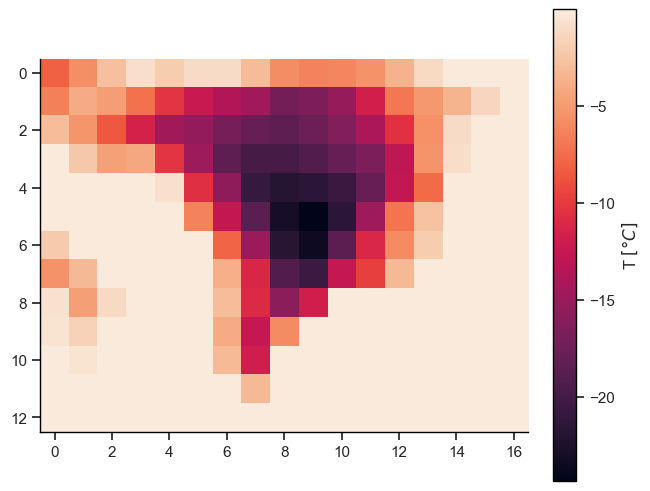

In [13]:
import matplotlib.pyplot as plt

[lat, lon] = [grp["lat"][:], grp["lon"][:]]
tas = grp["tas"][:, (lat >= 59) & (lat <= 83), (lon >= 286) & (lon <= 349)]
mask = tas[-1] < 273.15
x = tas[-1]

x[mask] = x[mask]
x[~mask] = 273.15

plt.imshow(x[::-1] - 273.15)
plt.grid(False)
plt.colorbar(label=r"T $[\degree C]$");

Averaging these temperatures over time then gives a curve that we'll smooth a little bit using a rolling mean:

temps = [240.47 242.   243.91 ... 268.34 265.52 263.22]
yrs = [2006 2006 2006 ... 2300 2300 2300]
chunked =
	[[240.47 242.   243.91 ... 254.38 248.07 241.32]
	 [238.61 239.11 243.87 ... 252.68 246.61 243.23]
	 [239.68 240.64 243.54 ... 251.35 243.64 242.59]
	 ...
	 [258.91 263.27 261.72 ... 269.57 265.38 262.05]
	 [258.28 257.18 258.25 ... 269.48 267.91 264.15]
	 [258.52 259.41 260.15 ... 268.34 265.52 263.22]]


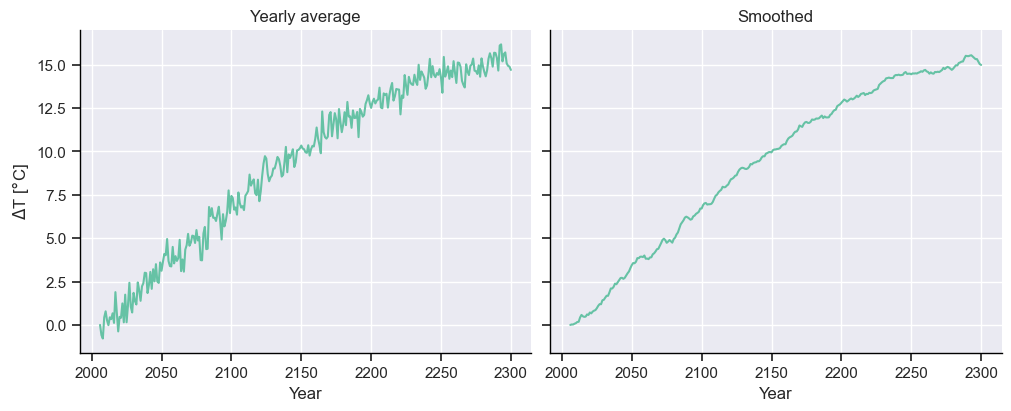

In [32]:
temps = np.mean(np.asarray(tas[:, mask]), axis=-1)
print(f"temps = {temps}")

yrs = np.array(grp.variables["time"][:] // 365).astype(int) + 2006
print(f"yrs = {yrs}")

chunked = np.array([temps[yrs == yr] for yr in np.unique(yrs)])
print(f"chunked =\n{"\n\t".join(["", *f"{chunked}".split("\n")])[1:]}")

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4))

avgs = np.mean(chunked, axis=-1)
axes[0].plot(np.unique(yrs), avgs - avgs[0])  # Kelvin difference == Celsius difference
axes[0].set_ylabel(r"$\Delta$T [$\degree$C]")
axes[0].set_title("Yearly average")


def smooth(x: np.ndarray, wlen: int) -> np.ndarray:
    w = np.ones(wlen, "d")
    padded = np.pad(x, (wlen // 2, wlen - 1 - wlen // 2), mode="edge")
    return np.convolve(padded, w / w.sum(), mode="valid")


smoothed_temps = smooth(avgs, 10)
axes[1].plot(np.unique(yrs), smoothed_temps - smoothed_temps[0])
axes[1].set_title("Smoothed")
[ax.set_xlabel("Year") for ax in axes];

Nice! We now have the temperature increase with respect to the starting year 2006. What's left is to offset this curve by the actual temperature it was in 2006, and then we write this out to a file SICOPOLIS understands. To do this, have a look at the file `sico_in/general/grl_warming_scenario_rcp26.asc`. This file contains Greenland surface temperature *anomalies* (which is strictly speaking also what we've been dealing with: departures from a reference temperature, which we've set at 0). The file format is a tad undocumented, but the first line contains a comment specifying `# <START_YEAR_OFFSET> <TIMESTEP> <END_YEAR_OFFSET>`, all times and values being relative to 1990 (the common start year for SICOPOLIS runs). Each line then contains a year and a temperature value: the first line has the year -140, which relative to 1990 is 1850, and the comment at the bottom also confirms this.

Our current temperature anomalies are relative to the year 2006, but we should make it relative to 1990. To do this, we'll simply find the anomaly during 2006 in the file and add it to our temperatures. We'll also make the years relative to 1990.

In [10]:
dt_2006 = 5.8161056e-01

time = np.unique(yrs) - 1990
dtemps = (smoothed_temps - smoothed_temps[0]) + dt_2006
print(len(time), len(dtemps))

295 295


We'll write this out to a file so we can use it later.

In [11]:
start, end = time[[0, -1]]
step = time[1] - time[0]

contents = f"""#  {start}  {step}  {end}
{"\n".join([f"  {yr}  {t}" for yr, t in zip(time, dtemps)])}

# --------------------------------------------------------------------------------
# Greenland surface temperature anomaly from RCP8.5 scenario for years 2006 - 2300
# Year (relative to 1990 CE) - Delta T [C]
# --------------------------------------------------------------------------------
"""

with open(f"{DATA_DIR}/grl_rcp85.dat", "w") as f:
    f.write(contents)

## Running the model


Now that we have our inputs done, we can actually run the model. SICOPOLIS runs are specified by so-called "header" files, which you'll find in the `headers` directory. We're going to base our run on the existing file `sico_specs_repo_grl10_b2_future21_asmb.h`. I'm changing the resolution from $10$ to $20$ km to speed up our simulation (we can run the [resolution doubler](https://sicopolis.readthedocs.io/en/develop/plotting_and_tools.html#resolution-doubler) afterwards if necessary for plotting), and also the start and end time, to make sure it runs during the range of our data (2006 - 2300). I'm also setting `GRIP_TEMP_FILE` to our newly created temperature anomalies, and specifying the time-slices at which I want data to be written out using `TIME_OUT0`. The changes I made are these:

<Note type="info">
  These header files are quite dense: make sure to read the comments and refer to the documentation if you don't understand something. Note that the SICOPOLIS calendar starts at `YEAR_ZERO`, which by default is 1990 (I don't recommend changing this). The time unit of "a" just means year ("a" for the Latin word "annus").
</Note>

<Code
  language="fortran"
  hasCopyButton
  oldFilename="sico_specs_repo_grl10_b2_future21_asmb.h"
  filename="sico_specs_grl20_rcp85.h"
  oldValue="file:./data/sico_specs_repo_grl10_b2_future21_asmb.h"
  value="file:./data/sico_specs_grl20_rcp85.h"
/>

Since our initial conditions depend on the result of *another* simulation (as specified by `ANF_DAT=3`), we'll have to run that one first. This script will run both models for you:

<Code
  hasCopyButton
  language="bash"
>
{`# first run took around ~1h on my machine
(./sico.sh -f -m repo_grl20_b2_paleo21) >tmp/out_001.dat;
(./sico.sh -f -m grl20_rcp85 -a $SICOPOLIS_DIR/sico_out/repo_grl20_b2_paleo21) >tmp/out_001.dat`}
</Code>

<Note type="warning">
  The `-a` flag doesn't take relative paths, so make sure your path is absolute: no `-a ./sico_in/...`, but rather `-a /home/user/sicopolis/sico_in/...`.
</Note>

## Processing output data


Once that is done, your output files will be in the folder `sico_out/grl20_rcp85` (or whatever name you gave to your specfile). An explanation of what these different files contain can be found [here](https://sicopolis.readthedocs.io/en/develop/getting_started.html#getting-started-output), but the gist of it is that the `.ser` or `_ser.nc` files contain scalar variables (`ser` meaning time series), the `.site` or `_site.nc` also contain (different) scalar variables sampled at particular *sites* (which are predefined and specific to your modeling domain), and the files that end in `0001.nc`, `0002.nc` etc. contain full 2D/3D fields (e.g. ice velocity or thickness). These fields are written out at the times we set on line 1322 of our specfile, so in our case it's once every 50 years.

Your directory should look something like this:

<FileTree
  items={[
    {
      name: "sico_out",
      items: [{
        name: "grl20_rcp85",
        items: [
          "grl20_rcp85.core",
          "out_grl20_rcp85.dat",
          "sico_specs_grl20_rcp85.h",
          "grl20_rcp85.log",
          "host_info.log",
          "grl20_rcp85_core.nc",
          "grl20_rcp85_ser.nc",
          "grl20_rcp850001.nc",
          "grl20_rcp850002.nc",
          "grl20_rcp850003.nc",
          "grl20_rcp850004.nc",
          "grl20_rcp850005.nc",
          "grl20_rcp850006.nc",
          "grl20_rcp850007.nc",
          "grl20_rcp85.ser",
        ]
      }]
    }
  ]}
/>

As a first sanity check, we'll get the surface temperature anomaly from the `grl20_rcp85_ser.nc` file to make sure that it corresponds to the input data we generated. I'll also calculate the expected sea level rise, because why not.

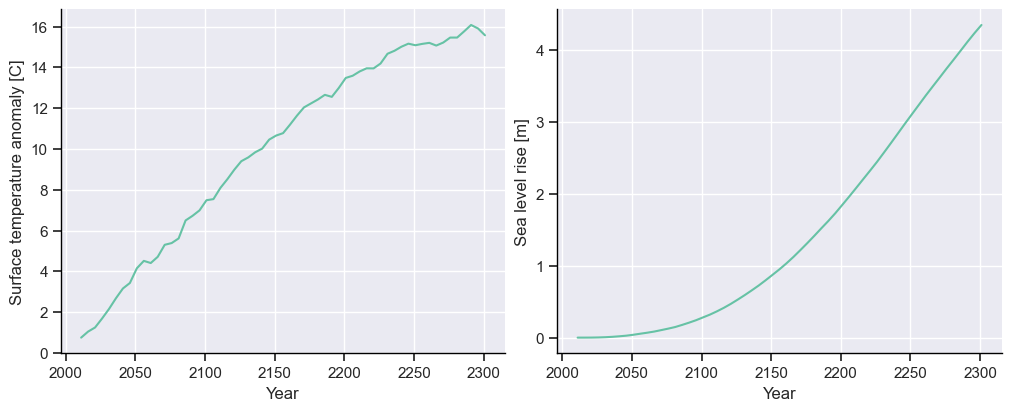

In [381]:
sim_name = "grl20_rcp85"
root = Path(SICOPOLIS_DIR, "sico_out", sim_name)
start_year = 1990

with Dataset((root / f"{sim_name}_ser.nc").absolute()) as ser:
    [time, delta_ts, V_sle] = [ser.variables[x][:] for x in ["t", "delta_ts", "V_sle"]]
    sle = (V_sle - V_sle[0]) * -1
    time += start_year

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(time, delta_ts)
axes[1].plot(time, sle)

axes[0].set_ylabel("Surface temperature anomaly [C]")
axes[1].set_ylabel("Sea level rise [m]")

for ax in axes:
    ax.set_xlabel("Year")

In order to create our final plots, I'll ...

<Collapsed>

In [402]:
filenames = [f"{root}/{sim_name}{i:04}.nc" for i in range(1, 7 + 1)]
keys = ["as_perp", "H", "lat", "lon", "mask", "zs", "cell_area", "temp_b", "vh_s", "ratio_sl"]

data = {}

for filename in filenames:
    with Dataset(filename) as grp:
        year = int(start_year + grp.variables["time"][:])
        print(f"{year = }")
        data[year] = {k: grp.variables[k][:] for k in keys}

year = 2006
year = 2056
year = 2106
year = 2156
year = 2206
year = 2256
year = 2301


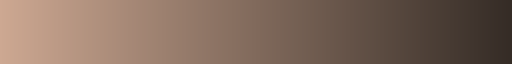

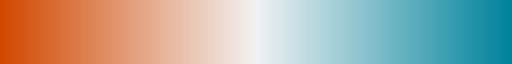

In [412]:
from matplotlib.colors import hex2color, LinearSegmentedColormap, BoundaryNorm

plot_years = [2006, 2106, 2206, 2301]
plot_data = {k: data[k] for k in plot_years}

rho_ice = 916.7  # [kg/m^3]
SMBs = [np.ma.masked_where(~(x["H"] > 0), x["as_perp"]) * rho_ice for x in plot_data.values()]

zs = [np.ma.masked_where(~((x["mask"] == 0) | (x["mask"] == 1)), x["zs"]) for x in plot_data.values()]
zs = [(x.min(), x.max()) for x in zs]

SMB_min, SMB_max = [np.min(SMBs), np.max(SMBs)]
SMB_absmax = np.abs([SMB_min, SMB_max]).max()
z_min, z_max = [np.min(zs), np.max(zs)]

land_cmap = LinearSegmentedColormap.from_list("", [hex2color("#cda892"), hex2color("#352c26")])
land_norm = plt.Normalize(vmin=z_min, vmax=z_max)

SMB_cmap = sns.diverging_palette(20, 220, s=100, as_cmap=True)
levels_pos = np.linspace(0.1, SMB_absmax, num=30)
levels_neg = np.linspace(-SMB_absmax, -0.1, num=30)
SMB_norm = BoundaryNorm([*levels_neg[:-1], 0, *levels_pos[1:]], SMB_cmap.N)

display(land_cmap)
display(SMB_cmap)

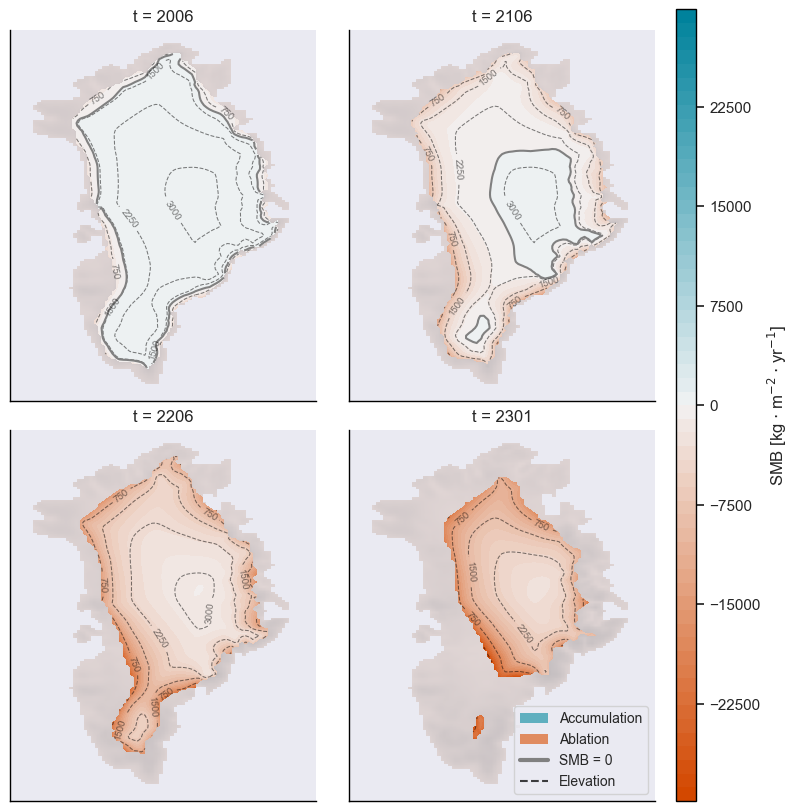

In [408]:
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(ncols * 4 + 1, nrows * 6), layout="constrained")
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 0.03])
axes = gs[0].subgridspec(nrows=nrows, ncols=ncols)

for i, (year, vars) in enumerate(plot_data.items()):
    ax = fig.add_subplot(axes[i // ncols, i % ncols])
    ax.set_title(f"t = {year:.0f}")

    as_perp, H, lat, lon, mask, zs = [*vars.values()][:6]
    land_mask = (mask == 0) | (mask == 1)
    ice_mask = H > 0
    SMB = np.ma.masked_where(~ice_mask, as_perp) * rho_ice

    x, y = [lon, lat]
    zs = zs.reshape(x.shape)
    land_zs = np.ma.masked_where(~land_mask, zs)

    extent = [x.min(), x.max(), y.min(), y.max()]
    kw = dict(extent=extent, origin="lower")

    _land = ax.imshow(land_zs, norm=land_norm, cmap=land_cmap, alpha=0.3, **kw)

    _pos = ax.contourf(SMB, cmap=SMB_cmap, levels=levels_pos, norm=SMB_norm, zorder=2, **kw)
    _neg = ax.contourf(SMB, cmap=SMB_cmap, levels=levels_neg, norm=SMB_norm, zorder=2, **kw)
    _equilibrium = ax.contour(
        SMB,
        levels=[0],
        linewidths=1.5,
        colors=[(0.5, 0.5, 0.5)],
        zorder=3,
        **kw,
    )

    elevation_levels = np.arange(0, np.ma.masked_where(~ice_mask, zs).max(), step=750)
    elevation = ax.contour(
        np.ma.masked_where(~ice_mask, zs),
        levels=elevation_levels,
        colors="black",
        alpha=0.5,
        linestyles="dashed",
        linewidths=0.75,
        **kw,
    )
    ax.clabel(
        elevation,
        inline=True,
        inline_spacing=1,
        fontsize=7,
        levels=np.intersect1d(elevation_levels, [750, 1500, 2250, 3000]),
    )

    ax.set_aspect(5)
    ax.set_xticks([])
    ax.set_yticks([])


cax = fig.add_subplot(gs[1])
cbar = fig.colorbar(
    ScalarMappable(norm=SMB_norm, cmap=SMB_cmap),
    label=r"SMB [kg $\cdot$ m$^{-2}$ $\cdot$ yr$^{-1}$]",
    cax=cax,
)
ticks = np.linspace(-np.round(SMB_absmax * 1e-4, 0) * 1e4, 0, 5)[1:]
cax.set_yticks(np.unique([*ticks, *(-ticks)]))
cax.set_yticks([], minor=True)

handles = [
    Patch(facecolor=SMB_cmap(1 - 0.2), linewidth=0, label="Accumulation"),
    Patch(facecolor=SMB_cmap(0.2), linewidth=0, label="Ablation"),
    Line2D([0], [0], color=(0.5, 0.5, 0.5), linewidth=3, label="SMB = 0"),
    Line2D([0], [0], color="black", linestyle="dashed", alpha=0.75, label="Elevation"),
]

fig.get_axes()[-2].legend(handles=handles, loc="lower right", fontsize=10);

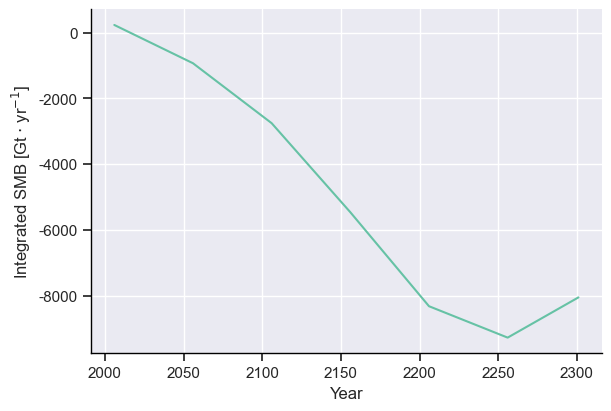

In [416]:
def calc_integrated_SMB(x: dict):
    return (np.ma.masked_where(~(x["H"] > 0), x["as_perp"]) * rho_ice * x["cell_area"]).sum()

integrated_SMBs = [calc_integrated_SMB(x) for x in data.values()]

fig, ax = plt.subplots(figsize=(6, 4), layout="constrained")
ax.plot([*data.keys()], integrated_SMBs)
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e12:.0f}")
ax.set_ylabel(r"Integrated SMB [Gt $\cdot$ yr$^{-1}$]")
ax.set_xlabel("Year");

-0.03686611 9984.137
0.0 9990.823
0.0 9990.823
0.0 9990.823


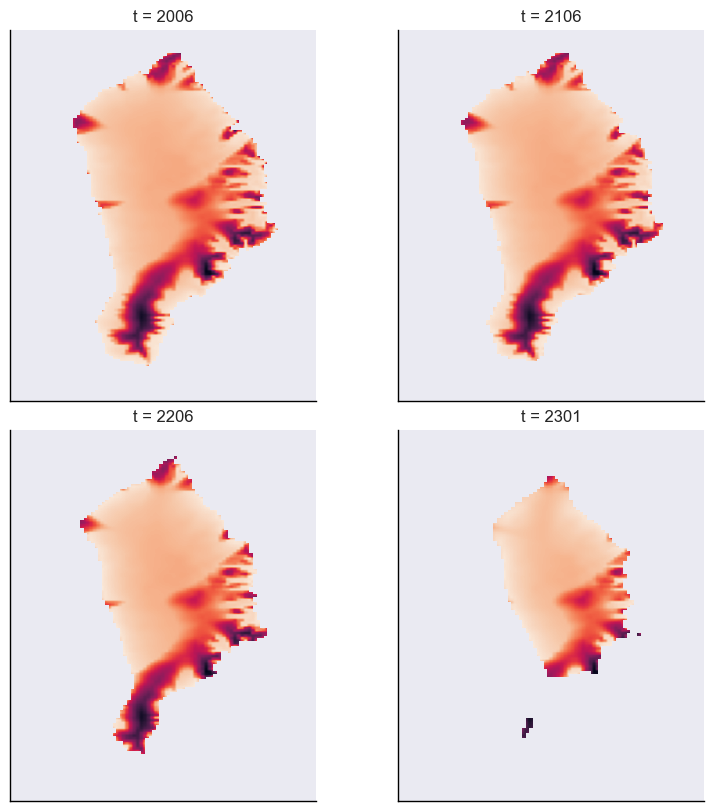

In [405]:
[nrows, ncols] = [2, 2]
fig = plt.figure(figsize=(ncols * 3.5 + 1, nrows * 4), layout="constrained")
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 0.03])
axes = gs[0].subgridspec(nrows=nrows, ncols=ncols)

for i, (year, d) in enumerate(plot_data.items()):
    ax = fig.add_subplot(axes[i // ncols, i % ncols])
    ax.set_title(f"t = {year:.0f}")

    land_mask = (d["mask"] == 0) | (d["mask"] == 1)
    ice_mask = d["H"] > 0

    x, y = [d["lon"], d["lat"]]
    zs = d["zs"].reshape(x.shape)
    land_zs = np.ma.masked_where(~land_mask, zs)

    extent = [x.min(), x.max(), y.min(), y.max()]
    kw = dict(extent=extent, origin="lower")
    # "temp_b", "vh_s", "ratio_sl"
    ax.imshow(
        np.ma.masked_where(~ice_mask, d["temp_b"]),
        **kw,
    )

    print(d["H_w"].min(), d["H_w"].max())

    ax.set_aspect(5)
    ax.set_xticks([])
    ax.set_yticks([])

</Collapsed>

## Conclusions